# GEDI Aboveground Biomass
## Overview
This tutorial will demonstrate how to directly access and subset the GEDI L2A canopy height metrics and L4A aboveground biomass dataset using [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) and compute a summary of aboveground biomass density for a forest reserve. The Harmony API allows seamless access and production of analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions. The GEDI datasets are available from the Harmony API.

```{admonition} Learning Objectives
- Use [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov/) to retrieve the GEDI L2A and L4A datasets. The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute summaries of AGBD across various plant functional types (PFTs) and canopy heights (RH100) in the study area.
```

## Dataset
The Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD) dataset {cite:p}`dubayah2022` provides predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated GEDI footprint. The GEDI Level 2A Geolocated Elevation and Height Metrics product (GEDI02_A) {cite:p}`dubayah2021` provides waveform interpretation and extracted products from eachreceived waveform, including ground elevation, canopy top height, and relative height (RH) metrics. GEDI datasets are available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L2A and L4A data files are natively in HDF5 format.
```{bibliography}
:style: plain
:filter: docname in docnames
```


Se debe instalar los paquetes faltantes, en caso de Google Colab me hicieron falta dos, contextily y nasa harmony

In [1]:
!pip install contextily
!pip install harmony-py

  Using cached contextily-1.7.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
Using cached contextily-1.7.0-py3-none-any.whl (16 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.6 MB/s eta 0:00:00
  Created wheel for curlify: filename=curlify-2.2.1-py3-none-any.whl size=2667 sha256=192c4abf68dc7c9a9fedd3d49a810257216352318c7bb7c04bd79abcf0eda31d
  Stored in directory: /root/.cache/pip/wheels/de/b1/32/218427ea0fc33dda6ec9259a8dbc440c6a04bd2f37c1d67a68
Successfully built curlify
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.2
    Uninstalling shapely-2.1.2:
      Successfully uninstalled shapely-2.1.2
  Attempting uninstall: python-dotenv
    Found existing installation: python-dotenv 1.2.1
    Uninstalling python-dotenv-1.2.1:
      Successfully uninstalled python-dotenv-1.2.1
  Attempting unin

In [1]:
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import Client, Collection, Environment, Request
import seaborn as sns
from os import path
sns.set(style='whitegrid')

## Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the [earthaccess](https://nsidc.github.io/earthaccess/) Python library to set up authentication. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:
```bash
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

## Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the `auth` parameter.

In [14]:
harmony_client = Client(auth=("aramides", "Thraupis%1976%episcopus"))

In [15]:
import os
os.environ['EARTHDATA_USERNAME'] = "aramides"
os.environ['EARTHDATA_PASSWORD'] = "Thraupis#1976#episcopus"

## Retrieve Concept ID
Now, let’s retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata’s unique ID for its dataset.

In [16]:
def get_concept_id(doi):
    """get concept id from DOI using CMR API"""
    doisearch = f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}'
    return re.get(doisearch).json()['feed']['entry'][0]['id']

concept_l4a = get_concept_id('10.3334/ORNLDAAC/2056') # GEDI L4A DOI
concept_l2a = get_concept_id( '10.5067/GEDI/GEDI02_A.002') # GEDI L2A DOI
# printing concept_ids
print(f"{concept_l4a}, {concept_l2a}")

C2237824918-ORNL_CLOUD, C2142771958-LPCLOUD


## Define Request Parameters

Let’s create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [17]:
# harmony collection
collection_l4a = Collection(id=concept_l4a)
collection_l2a = Collection(id=concept_l2a)

def create_var_names(variables):
    # gedi beams
    beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
    # combine variables and beam names
    return [f'/{b}/{v}' for b in beams for v in variables]

# gedi variables
variables_l4a = create_var_names(['agbd', 'l4_quality_flag', 'land_cover_data/pft_class'])
variables_l2a = create_var_names(['rh'])

# time range
temporal_range = {'start': datetime(2019, 4, 17),
                  'stop': datetime(2025, 10, 31)}

We will use the spatial extent of the [Reserva Florestal Adolpho Ducke](https://ppbio.inpa.gov.br/en/Sites/RFAD), a forest reserve near Manaus, Brazil, provided as a GeoJSON file at `assets/reserva_ducke.json`. Let’s open and plot this file.

In [18]:
poly_json = '/content/poligono_prueba.geojson'
poly = gpd.read_file(poly_json)
poly.explore(color='red',  fill=False)

## Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded.

In [20]:
def submit_harmony(collection, variables):
    """submit harmony request"""
    request = Request(collection=collection,
                  variables=variables,
                  temporal=temporal_range,
                  shape=poly_json,
                  ignore_errors=True)

    # submit harmony request, will return job id
    subset_job_id = harmony_client.submit(request)
    print(f'Processing job: {subset_job_id}')
    print(f'Waiting for the job to finish')
    results = harmony_client.result_json(subset_job_id, show_progress=True)
    print(f'Downloading subset files...')
    futures = harmony_client.download_all(subset_job_id, directory="/content/downloads", overwrite=True)
    for f in futures:
        # all subsetted files have this suffix
        if f.result().endswith('subsetted.h5'):
            print(f'Downloaded: {f.result()}')
    print(f'Done downloading files.')

submit_harmony(collection_l4a, variables_l4a)
submit_harmony(collection_l2a, variables_l2a)

Processing job: b93e36f5-ca99-4afa-afd3-05800d46efab
Waiting for the job to finish


 [ Processing: 100% ] |###################################################| [|]


/content/downloads/132901083_GEDI04_A_2019322213501_O05294_02_T01850_02_002_02_V002_subsetted.h5
Downloaded: /content/downloads/132901083_GEDI04_A_2019322213501_O05294_02_T01850_02_002_02_V002_subsetted.h5
/content/downloads/132901082_GEDI04_A_2019273170356_O04531_02_T03120_02_002_02_V002_subsetted.h5
Downloaded: /content/downloads/132901082_GEDI04_A_2019273170356_O04531_02_T03120_02_002_02_V002_subsetted.h5
/content/downloads/132901081_GEDI04_A_2019130130016_O02309_03_T01444_02_002_02_V002_subsetted.h5
Downloaded: /content/downloads/132901081_GEDI04_A_2019130130016_O02309_03_T01444_02_002_02_V002_subsetted.h5
/content/downloads/132901085_GEDI04_A_2020062041900_O06911_02_T00274_02_002_02_V002_subsetted.h5
Downloaded: /content/downloads/132901085_GEDI04_A_2020062041900_O06911_02_T00274_02_002_02_V002_subsetted.h5
/content/downloads/132901087_GEDI04_A_2020089172504_O07338_02_T01850_02_002_02_V002_subsetted.h5
Downloaded: /content/downloads/132901087_GEDI04_A_2020089172504_O07338_02_T0185

 [ Processing: 100% ] |###################################################| [|]


/content/downloads/132901544_GEDI02_A_2020328185111_O11044_02_T07389_02_003_02_V002_subsetted.h5
Downloaded: /content/downloads/132901544_GEDI02_A_2020328185111_O11044_02_T07389_02_003_02_V002_subsetted.h5
/content/downloads/132901559_GEDI02_A_2024150023151_O30928_04_T08406_02_004_02_V002_subsetted.h5
Downloaded: /content/downloads/132901559_GEDI02_A_2024150023151_O30928_04_T08406_02_004_02_V002_subsetted.h5
/content/downloads/132901540_GEDI02_A_2020066024513_O06972_02_T03120_02_003_01_V002_subsetted.h5
Downloaded: /content/downloads/132901540_GEDI02_A_2020066024513_O06972_02_T03120_02_003_01_V002_subsetted.h5
/content/downloads/132901545_GEDI02_A_2021057052958_O12508_02_T07389_02_003_02_V002_subsetted.h5
Downloaded: /content/downloads/132901545_GEDI02_A_2021057052958_O12508_02_T07389_02_003_02_V002_subsetted.h5
/content/downloads/132901560_GEDI02_A_2024295165251_O33186_04_T01291_02_004_02_V002_subsetted.h5
Downloaded: /content/downloads/132901560_GEDI02_A_2024295165251_O33186_04_T0129

## Read Subset files
All the subsetted files are saved as `_subsetted.h5`. Let’s read these `h5` files into the pandas dataframe.


In [21]:
def read_gedi_vars(beam):
    """reads through gedi variable hierarchy"""
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        # check if the item is a group
        if isinstance(value, h5py.Group):
            # looping through subgroups
            for key2, value2 in value.items():
                col_names.append(key2)
                col_val.append(value2[:].tolist())
        else:
            col_names.append(key)
            col_val.append(value[:].tolist())
    return col_names, col_val

def get_rh100(rh):
    """get RH percentile"""
    return rh[100]

# define empty pandas dataframe
subset_df = pd.DataFrame()
for subfile in glob(path.join('/content/downloads', '*GEDI04_A*_subsetted.h5')):
    l4a_in = h5py.File(subfile, 'r')
    orbit = "_".join(path.basename(subfile).split("_")[3:7])
    l2a_f = glob(path.join('downloads', f'*GEDI02_A*{orbit}*_subsetted.h5'))[0]
    l2a_in = h5py.File(l2a_f, 'r')
    for v in list(l4a_in.keys()):
        if v.startswith('BEAM'):
            c_n_l4a, c_v_l4a = read_gedi_vars(l4a_in[v])
            c_n_l2a, c_v_l2a = read_gedi_vars(l2a_in[v])
            c_v = c_v_l4a+c_v_l2a
            c_n = c_n_l4a+c_n_l2a
            # Appending to the subset_df dataframe
            subset_df = pd.concat([subset_df,
                                   pd.DataFrame(map(list, zip(*c_v)), columns=c_n)])

    l4a_in.close()
    l2a_in.close()
# remove duplicate columns
subset_df = subset_df.loc[:,~subset_df.columns.duplicated()].copy()
# compute rh100
subset_df['rh100'] = subset_df['rh'].apply(get_rh100)
# print the first row of dataframe
subset_df.head(2)

,agbd,delta_time,lat_lowestmode_a1,lon_lowestmode_a1,shot_number,l4_quality_flag,pft_class,lat_lowestmode,lon_lowestmode,rh,rh100
0,128.607239,1.232688e+08,0.338850,-72.758354,167620000200057236,1,2,0.338849,-72.758365,"[-2.119999885559082, -1.75, -1.299999952316284...",25.459999
1,32.049816,1.232688e+08,0.339274,-72.758057,167620000200057237,1,2,0.339273,-72.758064,"[-1.559999942779541, -1.2300000190734863, -0.8...",10.640000


## Quality Filter and Plot
We can now quality filter the dataset and only retrieve the good quality shots for trees and shrub cover plant functional types (PFTs).

In [22]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies',
              1: 'Evergreen Needleleaf Trees',
              2: 'Evergreen Broadleaf Trees',
              3: 'Deciduous Needleleaf Trees',
              4: 'Deciduous Broadleaf Trees',
              5: 'Shrub',
              6: 'Grass',
              7: 'Cereal Croplands',
              8: 'Broadleaf Croplands',
              9: 'Urban and Built-up Lands',
              10: 'Permanent Snow and Ice',
              11: 'Barren',
              255: 'Unclassified'}

# create geopandas dtframe
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode), crs="EPSG:4326")
# creating mask with good quality shots and trees/shrubs pft class
mask = (gdf['l4_quality_flag']==1) & (gdf['pft_class'] <= 5 )
# plotting
gdf = gdf[['lat_lowestmode', 'lon_lowestmode', 'rh100', 'pft_class', 'agbd', 'geometry']]
gdf[mask].explore("agbd", vmax=300, cmap = "YlGn", alpha=0.5, radius=10, legend=True)

We will plot the distribution of the AGBD by plant functional types (PFTs) for good quality shots.

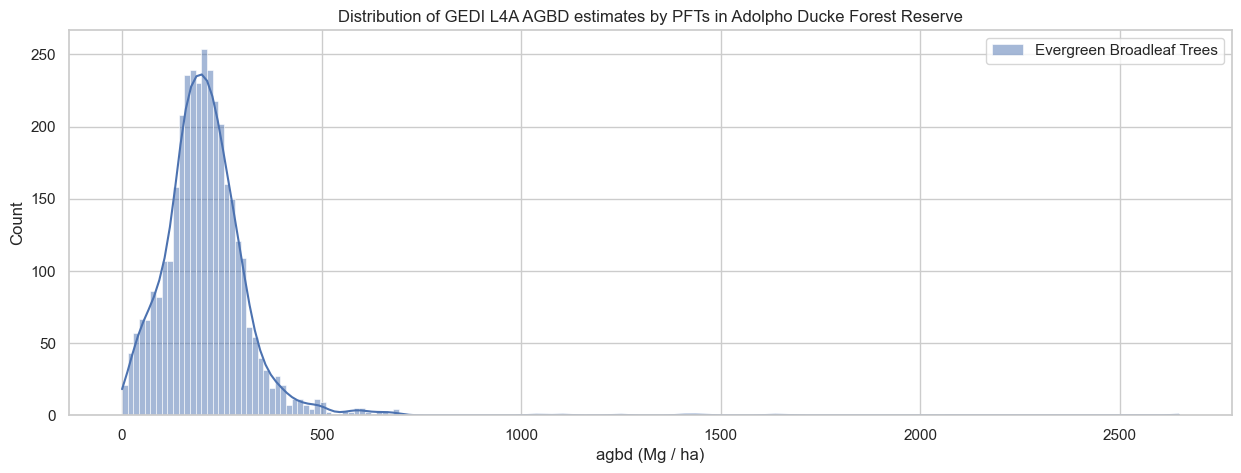

In [ ]:
plt.figure(figsize=(15,5))
ax = gdf[mask].groupby('pft_class')['agbd'].\
            apply(lambda x: sns.histplot(x, label = pft_legend[x.name], kde=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs in Adolpho Ducke Forest Reserve')
plt.legend()
plt.show()

Let’s also plot how the AGBD is distributed across elevation ranges for different PFTs.


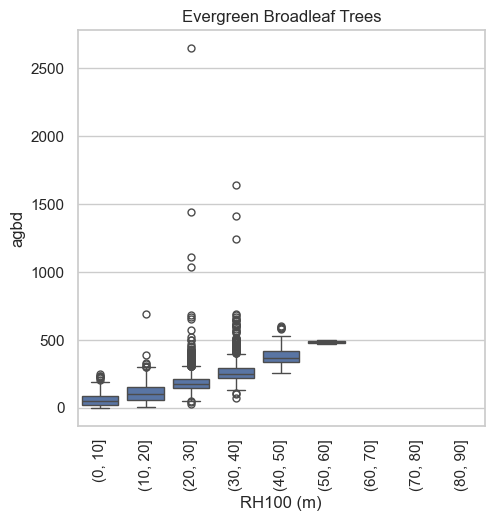

In [ ]:
gdf['elev_bin']=pd.cut(gdf['rh100'], bins =range(0, 100, 10))
g = sns.catplot(x = "elev_bin", y = "agbd", data = gdf[mask], col="pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("RH100 (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)